In [1]:
import glob
import os
import time
import csv

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
os.environ['CUDA_VISIBLE_DEVICES']='0'

import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
import h5py
# import imageio
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.autograd import Variable
import torch.autograd as autograd
import torchvision.utils as vutils

# from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset

In [2]:
def load_data(size):
    hfs = 48 # half full size 96/2=48
    hs = size//2
    start = hfs-hs
    end = hfs+hs
    
    X = np.load('X_clean.npy')[:, start:end, start:end]/255
    X = np.moveaxis(X, -1, 1).astype(np.float32)
    y = np.load('Y_clean.npy').reshape(-1,1).astype(np.float32)
    wsi = np.load('WSI_clean.npy')
    
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    
#     X_0 = torch.from_numpy(X[WSI==0])
#     X_1 = torch.from_numpy(X[WSI==1])
#     Y_0 = torch.from_numpy(Y[WSI==0])
#     Y_1 = torch.from_numpy(Y[WSI==1])
#     return X_0, Y_0, X_1, Y_1

    return X, y, wsi

In [4]:
X, y, wsi = load_data(48)

X = torch.from_numpy(X)
y = torch.from_numpy(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

trainloader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
valloader = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
testloader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
# plt.hist(y_train_small.numpy(), bins=2)

In [5]:
def eval_Clf(model, validation_loader):
    model.eval()        
    with torch.no_grad():
        acc = .0
        for i, data in enumerate(validation_loader):
            X = data[0].cuda()
            y = data[1].cuda()
#             predicted = torch.argmax(model(X), dim=1)
            predicted = torch.round(model(X))
            acc+=(predicted == y).sum()/float(predicted.shape[0])       
    model.train()
    return (acc/(i+1)).detach().item()

In [6]:
class Classifier(nn.Module):
    def __init__(self, size):
        super(Classifier, self).__init__()
        
        s = size // 4
        s*=s
        n_filters = 16
        
        self.net = nn.Sequential(
            nn.Conv2d(3, n_filters, 3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(n_filters, 2*n_filters, 3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=0.2),
            
            nn.Conv2d(2*n_filters, 4*n_filters, 3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Flatten(),
            
            nn.Linear(4*n_filters*s, 256, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Linear(256, 128, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            
            nn.Linear(128, 256, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(p=0.2),

            nn.Linear(256, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [7]:
class Training:
    def __init__(self, model, model_name, cuda_device='cuda:0', lr=1e-4, early_stopping_count=20):
        self.model_name = model_name
        self.early_stopping_count = early_stopping_count
        
        device = 'cpu'
        if torch.cuda.is_available():
            device = cuda_device
        self.device = torch.device(device)
        
        self.Clf = model.to(self.device)

        self.Clf_opt = optim.Adam(self.Clf.parameters(), lr=lr)
        self.Clf_criterion = torch.nn.BCELoss()
        
        self.path = 'results/'+model_name
        
        self.best_acc = .0
        self.best_acc_count = 0

        if not os.path.exists(self.path):
            os.mkdir(self.path)

    def train(self, train_loader, validation_loader, epochs):

        self.stats = {
            'clf_loss': [],
            'clf_acc': [],
            'clf_loss_val': [],
            'clf_acc_val': [],
            
        }

        for epoch in range(epochs):
            clf_loss = []
            clf_acc = []

            for i, data in enumerate(train_loader):
                X = data[0].to(self.device)
                y = data[1].to(self.device)
                    
                loss, acc = self._train_Clf(X, y)
                clf_loss.append(loss)
                clf_acc.append(acc)                                
            
#             if epoch % 10 == 0:
            acc_val = eval_Clf(self.Clf, validation_loader)
            clf_loss_m = sum(clf_loss)/len(clf_loss)
            clf_acc_m = sum(clf_acc)/len(clf_acc)     
            self.stats['clf_loss'].append(clf_loss_m)
            self.stats['clf_acc'].append(clf_acc_m)
#             self.stats['clf_loss_val'].append(loss_val)
            self.stats['clf_acc_val'].append(acc_val)

            self.best_acc_count+=1
            if acc_val > self.best_acc:
                self.best_acc = acc_val
                self.best_acc_count = 0
                self.save_best()
    
            print("Epoch: %d, loss: %f, acc: %.3f, acc_val: %.3f"%(epoch, clf_loss_m, clf_acc_m, acc_val))
            
            if self.best_acc_count >= self.early_stopping_count:
                break
        print("Finished. Best acc: %.3f"%(self.best_acc))

#     def _eval_Clf(self, validation_loader):
#         self.Clf.eval()        
#         with torch.no_grad():
#             acc = .0
#             for i, data in enumerate(validation_loader):
#                 X = data[0].to(self.device)
#                 y = data[1].to(self.device)

#                 predicted = torch.argmax(self.Clf(X), dim=1)
#                 acc+=(predicted == y).sum()/float(predicted.shape[0])       
#         self.Clf.train()
#         return (acc/(i+1)).detach().item()

    def _train_Clf(self, data, labels):
        self.Clf_opt.zero_grad()
        
        predicted = self.Clf(data)
    
        loss = self.Clf_criterion(predicted, labels)
        
        loss.backward()
        self.Clf_opt.step()    
      
        acc = (np.round(predicted.detach().cpu()) == labels.detach().cpu()).sum()/float(predicted.shape[0])
#         acc = (torch.argmax(predicted.detach().cpu(), dim=1) == labels.detach().cpu()).sum()/float(predicted.shape[0])

        return loss.detach().item(), acc.item()

    def save_best(self):
        torch.save(self.Clf.state_dict(), self.path+'/best_model.pth')
        np.save(self.path+'/acc_val.npy', t.stats['clf_acc_val'], allow_pickle=False)
        np.save(self.path+'/acc.npy', t.stats['clf_acc'], allow_pickle=False)
        np.save(self.path+'/loss.npy', t.stats['clf_loss'], allow_pickle=False)


In [8]:
t = Training(Classifier(X.shape[2]), 'cnn_clf_48')
t.train(trainloader, valloader, 100)

Epoch: 0, loss: 0.565547, acc: 0.707, acc_val: 0.763
Epoch: 1, loss: 0.492278, acc: 0.770, acc_val: 0.760
Epoch: 2, loss: 0.473175, acc: 0.781, acc_val: 0.767
Epoch: 3, loss: 0.462140, acc: 0.787, acc_val: 0.753
Epoch: 4, loss: 0.453099, acc: 0.791, acc_val: 0.755
Epoch: 5, loss: 0.443535, acc: 0.797, acc_val: 0.767
Epoch: 6, loss: 0.436583, acc: 0.801, acc_val: 0.778
Epoch: 7, loss: 0.429634, acc: 0.805, acc_val: 0.777
Epoch: 8, loss: 0.421366, acc: 0.810, acc_val: 0.777
Epoch: 9, loss: 0.414453, acc: 0.814, acc_val: 0.772
Epoch: 10, loss: 0.409215, acc: 0.817, acc_val: 0.784
Epoch: 11, loss: 0.402636, acc: 0.821, acc_val: 0.772
Epoch: 12, loss: 0.395074, acc: 0.826, acc_val: 0.780
Epoch: 13, loss: 0.389194, acc: 0.829, acc_val: 0.778
Epoch: 14, loss: 0.381473, acc: 0.833, acc_val: 0.792
Epoch: 15, loss: 0.373718, acc: 0.838, acc_val: 0.795
Epoch: 16, loss: 0.365419, acc: 0.843, acc_val: 0.798
Epoch: 17, loss: 0.359576, acc: 0.846, acc_val: 0.809
Epoch: 18, loss: 0.351546, acc: 0.850,

In [11]:
model = Classifier(48)
model.load_state_dict(torch.load('results/cnn_clf_1_48/best_model.pth'))
model.cuda()

eval_Clf(model, valloader), eval_Clf(model, testloader)

(0.8669698238372803, 0.8646843433380127)

In [17]:
model = Classifier(48)
model.load_state_dict(torch.load('results/cnn_clf_48/best_model.pth'))
model.cuda();

In [ ]:
eval_Clf(model, valloader), eval_Clf(model, testloader)

In [15]:
(np.load('results/cnn_clf_48/acc_val.npy')[-1], 
np.load('results/cnn_clf_0_48/acc_val.npy')[-1],
np.load('results/cnn_clf_1_48/acc_val.npy')[-1])

(0.8299145698547363, 0.8211551308631897, 0.8675994873046875)

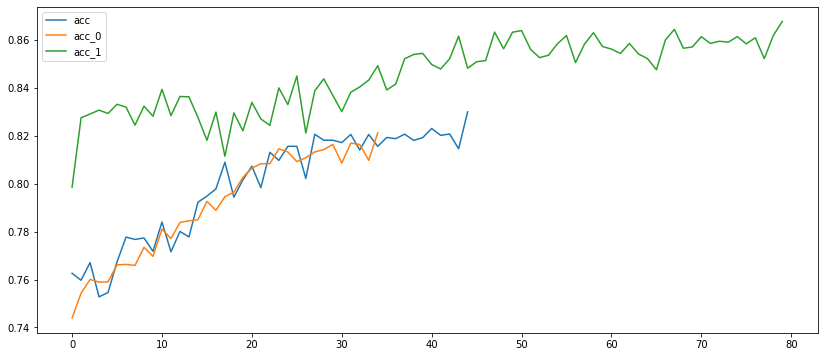

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(np.load('results/cnn_clf_48/acc_val.npy'), label='acc')
plt.plot(np.load('results/cnn_clf_0_48/acc_val.npy'), label='acc_0')
plt.plot(np.load('results/cnn_clf_1_48/acc_val.npy'), label='acc_1')
plt.legend()

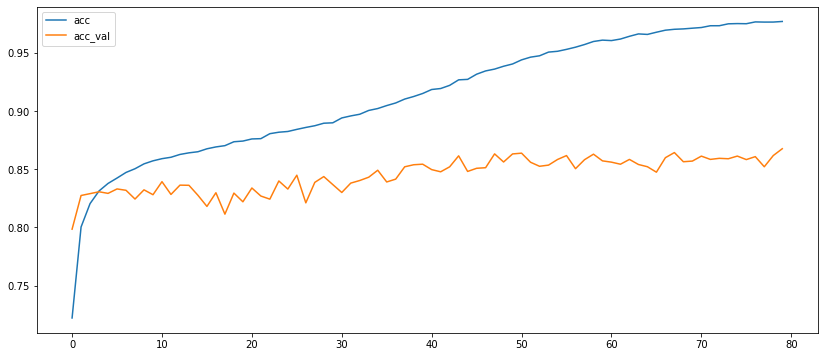

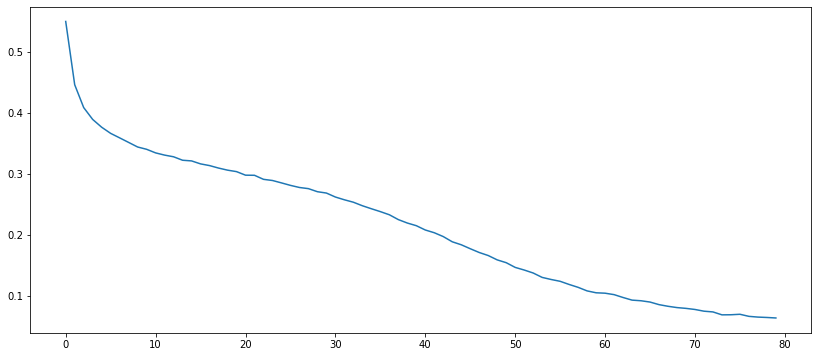

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(np.load('results/cnn_clf_1_48/acc.npy'), label='acc')
plt.plot(np.load('results/cnn_clf_1_48/acc_val.npy'), label='acc_val')
plt.legend()

plt.figure(figsize=(14, 6))
plt.plot(np.load('results/cnn_clf_1_48/loss.npy'), label='loss')

In [59]:
path = 'results/'+mixed_clf.model_name
with open(path+'/mixed_clf_fake_loss.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(mixed_clf.stats['clf_loss'])

with open(path+'/mixed_clf_fake_acc_val.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(mixed_clf.stats['clf_acc_val'])

with open(path+'/mixed_clf_fake_acc.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(mixed_clf.stats['clf_acc'])
    
# print(np.argmax(wgan_ct.stats['clf_acc_val']))
# wgan_ct.stats['clf_acc_val'][3]

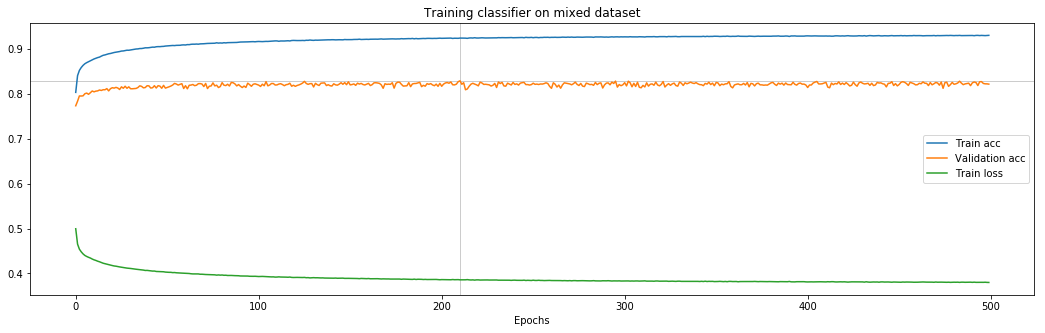

In [58]:
plt.figure(figsize=(18,5))
plt.title('Training classifier on mixed dataset')
acc_max = np.max(mixed_clf.stats['clf_acc_val'])
acc_max_e = np.argmax(mixed_clf.stats['clf_acc_val'])
plt.axhline(y=acc_max, color='k', linestyle='-', alpha=0.2, linewidth=1)
plt.axvline(x=acc_max_e, color='k', linestyle='-', alpha=0.2, linewidth=1)
plt.plot(mixed_clf.stats['clf_acc'], label='Train acc')
plt.plot(mixed_clf.stats['clf_acc_val'], label='Validation acc')
plt.plot(mixed_clf.stats['clf_loss'], label='Train loss')
plt.xlabel('Epochs')
plt.legend()